In [142]:
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import pylab as plt
import matplotlib.patches as patches
from Bio import SeqIO
import shutil
import math

from evaluation_functions import read_filtering, read_sequences, get_variants
from importlib import reload


In [138]:
## reload the evaluation functions
import evaluation_functions
reload(evaluation_functions)
from evaluation_functions import read_filtering, read_sequences, get_variants

In [27]:
base_dir = os.getcwd()
R5_Pool_seq = "GGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTC"

catch_left = "ACACTCTTTCCCTACACGACGCTCTTCCGATCT" ## Adapter fwd
catch_right = "GACTGGAGTTCAGACGTGTGCTCTTCCGATCT"

Barcodes = {"BC1_Fwd": "AAGG",
            "BC1_Rev": "ATCA",
            "BC2_Fwd": "AGTC",
            "BC2_Rev": "GCCG",
            "BC3_Fwd": "AGGA",
            "BC3_Rev": "AATT",
            "BC4_Fwd": "GCGA",
            "BC4_Rev": "TGGT",
            }

S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC"
S1_rev_primer = "TCGGCCAGTTCAGCCATTCA"
S1_rev_primer_compseq = dna_rev_comp(S1_rev_primer)
S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG"
S2_rev_primer = "TAGCACGGTCAGTCTCTGGC"
S2_rev_primer_compseq = dna_rev_comp(S2_rev_primer)
S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC"
S3_rev_primer = "ACATGCTGCGCCACGCTC"
S3_rev_primer_compseq = dna_rev_comp(S3_rev_primer)
S4_fwd_primer = "GATAACCGCGTGCGCGAA"
S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
S4_rev_primer_compseq = dna_rev_comp(S4_rev_primer)

Primer_seq = dict(
            S1_fwd_primer = "GGCGCAACTATCGGTATCAAGC",
            S1_rev_primer = "TCGGCCAGTTCAGCCATTCA",
            S2_fwd_primer = "ATTATGGCCGCCATCCGGAAGCG",
            S2_rev_primer = "TAGCACGGTCAGTCTCTGGC",
            S3_fwd_primer = "GTCCGATAGCTTCCTGCAATTAACC",
            S3_rev_primer = "ACATGCTGCGCCACGCTC",
            S4_fwd_primer = "GATAACCGCGTGCGCGAA",
            S4_rev_primer = "GAACTGGCATGATTAAGACTCCTTATTACG" 
)

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}

codons = list(genetic_code.keys())

quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

Primer_out_of_triplets = {"S1_fwd_primer": 0, ##??
                     "S1_rev_primer": 1, 
                     "S2_fwd_primer": 2,
                     "S2_rev_primer": 1,
                     "S3_fwd_primer": 1,
                     "S3_rev_primer": 2,
                     "S4_fwd_primer": 0,
                     "S4_rev_primer": 0} ##??

In [116]:
def demultiplex_reads(a_seqs, b_seqs,ref_gene, used_Barcodes, Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 1, filter_for_n_mut = True, n_mut_treshold = 20, a_ids = None, b_ids = None):

    read_Dict = {}
    ids_Dict = {}
    ## split the reads into the samples according to Barcode and AraC section -> thereby keeping the forward and reverse reads together
    for Barcode in used_Barcodes: 
        print(Barcode)
        for Section in Sections:
            fwd_BC_Primer_seq = Barcodes[Barcode + "_Fwd"] + Primer_seq[Section+"_fwd_primer"] 
            rev_BC_Primer_seq = Barcodes[Barcode + "_Rev"] + Primer_seq[Section+"_rev_primer"] 
            ### select the reads that contain the forward and reverse BC + primer sequences, thereby allowing for 2 mismatches in the primer sequences but no errors in BCs
            fwd_idxs = [i for i, seq in enumerate(a_seqs) if (seq[:len(Barcodes[Barcode + "_Fwd"])] == Barcodes[Barcode + "_Fwd"] and  sum([sequence!=primer_ref for sequence, primer_ref in zip(seq[len(Barcodes[Barcode + "_Fwd"]):len(fwd_BC_Primer_seq)], Primer_seq[Section+"_fwd_primer"])]) <= max_mismatch_primerseq)]
                        
            rev_idxs = [i for i, seq in enumerate(b_seqs) if (seq[:len(Barcodes[Barcode + "_Rev"] )] == Barcodes[Barcode + "_Rev"] and sum([sequence!=primer_ref for sequence, primer_ref in zip(seq[len(Barcodes[Barcode + "_Rev"]):len(rev_BC_Primer_seq)], Primer_seq[Section+"_rev_primer"])]) <= max_mismatch_primerseq) ]

            indexes = set(fwd_idxs + rev_idxs)
            
            a_seq_Bc_Sec = [a_seqs[i] for i in indexes]
            b_seq_Bc_Sec = [b_seqs[i] for i in indexes]

            if a_ids and b_ids:
                a_ids_Bc_Sec = [a_ids[i].split(" ")[0] for i in indexes]
                b_ids_Bc_Sec = [b_ids[i].split(" ")[0]  for i in indexes]

            ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"]))+len(Primer_seq[Section+"_rev_primer"])]

            if filter_for_n_mut:
                a_seq_Bc_Sec, b_seq_Bc_Sec = read_filtering(a_seq_Bc_Sec, b_seq_Bc_Sec, catch_left = Barcodes[Barcode + "_Fwd"], catch_right = dna_rev_comp(Barcodes[Barcode + "_Rev"]), n_mut_treshold = n_mut_treshold, ref_gene = ref_seq_Section)

            print(len(a_seq_Bc_Sec), "reads")
            read_Dict[f"{Barcode}_{Section}_R1"] = a_seq_Bc_Sec
            read_Dict[f"{Barcode}_{Section}_R2"] = b_seq_Bc_Sec

            if a_ids and b_ids:
                ids_Dict[f"{Barcode}_{Section}_R1"] = a_ids_Bc_Sec
                ids_Dict[f"{Barcode}_{Section}_R2"] = b_ids_Bc_Sec

    if a_ids and b_ids:
        return  read_Dict, ids_Dict
    else:
        return read_Dict 


In [133]:
a_seq, b_seq, _, _, a_ids, b_ids= read_sequences(variant = "Mutagenesis", arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left=catch_left, catch_right=catch_right, return_qualities_ids=True)
ref_gene = R5_Pool_seq

Mutagenesis_reads, Mut_ids_Dict = demultiplex_reads(a_seq, b_seq, ref_gene, used_Barcodes = ["BC1", "BC2"], Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 1, filter_for_n_mut = False, n_mut_treshold = 20, a_ids=a_ids, b_ids=b_ids)

a_seq, b_seq, _, _, a_ids, b_ids = read_sequences(variant = "NegPosSelection", arbitrary_cutoff_a = False, arbitrary_cutoff_b = False, catch_left="", catch_right="", return_qualities_ids=True)

NegPosSelection_reads, NegPos_ids = demultiplex_reads(a_seq, b_seq, ref_gene, used_Barcodes = ["BC1", "BC2", "BC3", "BC4"], Sections = ["S1", "S2", "S3", "S4"], max_mismatch_primerseq = 1, filter_for_n_mut = False, n_mut_treshold = 20, a_ids=a_ids, b_ids=b_ids)

all_reads = {**{"Mutagenesis_"+key : value for key, value in Mutagenesis_reads.items()},**{"NegPosSelection_"+key : value for key, value in NegPosSelection_reads.items()}}

all_ids = {**{"Mutagenesis_"+key : value for key, value in Mut_ids_Dict.items()},**{"NegPosSelection_"+key : value for key, value in NegPos_ids.items()}}


total reads 32117
BC1
5644 reads
5706 reads
6723 reads
6837 reads
BC2
4854 reads
4328 reads
4877 reads
4484 reads
total reads 20769
BC1
2237 reads
2389 reads
2950 reads
2612 reads
BC2
2026 reads
2010 reads
2425 reads
2324 reads
BC3
1294 reads
1113 reads
1250 reads
1119 reads
BC4
879 reads
770 reads
923 reads
1026 reads


In [121]:
for key, ids in all_ids.items():
    print(key, len(ids))
    Name = key.split("_")[0] 
    Read_dir = key.split("_")[-1] 
    input_file = f"data/fastq/{Name}_{Read_dir}_001.fastq"
    output_file = f"{key}_001.fastq"

    records = (r for r in SeqIO.parse(input_file, "fastq") if r.id in ids)
    count = SeqIO.write(records, output_file, "fastq")
    print("Saved %i records from %s to %s" % (count, input_file, output_file))
    if count < len(ids):
        print("Warning %i IDs not found in %s" % (len(ids)-count, input_file))

Mutagenesis_BC1_S1_R1 5644
Saved 5644 records from data/fastq/Mutagenesis_R1_001.fastq to Mutagenesis_BC1_S1_R1_001.fastq
Mutagenesis_BC1_S1_R2 5644
Saved 5644 records from data/fastq/Mutagenesis_R2_001.fastq to Mutagenesis_BC1_S1_R2_001.fastq
Mutagenesis_BC1_S2_R1 5706
Saved 5706 records from data/fastq/Mutagenesis_R1_001.fastq to Mutagenesis_BC1_S2_R1_001.fastq
Mutagenesis_BC1_S2_R2 5706
Saved 5706 records from data/fastq/Mutagenesis_R2_001.fastq to Mutagenesis_BC1_S2_R2_001.fastq
Mutagenesis_BC1_S3_R1 6723
Saved 6723 records from data/fastq/Mutagenesis_R1_001.fastq to Mutagenesis_BC1_S3_R1_001.fastq
Mutagenesis_BC1_S3_R2 6723
Saved 6723 records from data/fastq/Mutagenesis_R2_001.fastq to Mutagenesis_BC1_S3_R2_001.fastq
Mutagenesis_BC1_S4_R1 6837
Saved 6837 records from data/fastq/Mutagenesis_R1_001.fastq to Mutagenesis_BC1_S4_R1_001.fastq
Mutagenesis_BC1_S4_R2 6837
Saved 6837 records from data/fastq/Mutagenesis_R2_001.fastq to Mutagenesis_BC1_S4_R2_001.fastq
Mutagenesis_BC2_S1_R1 48

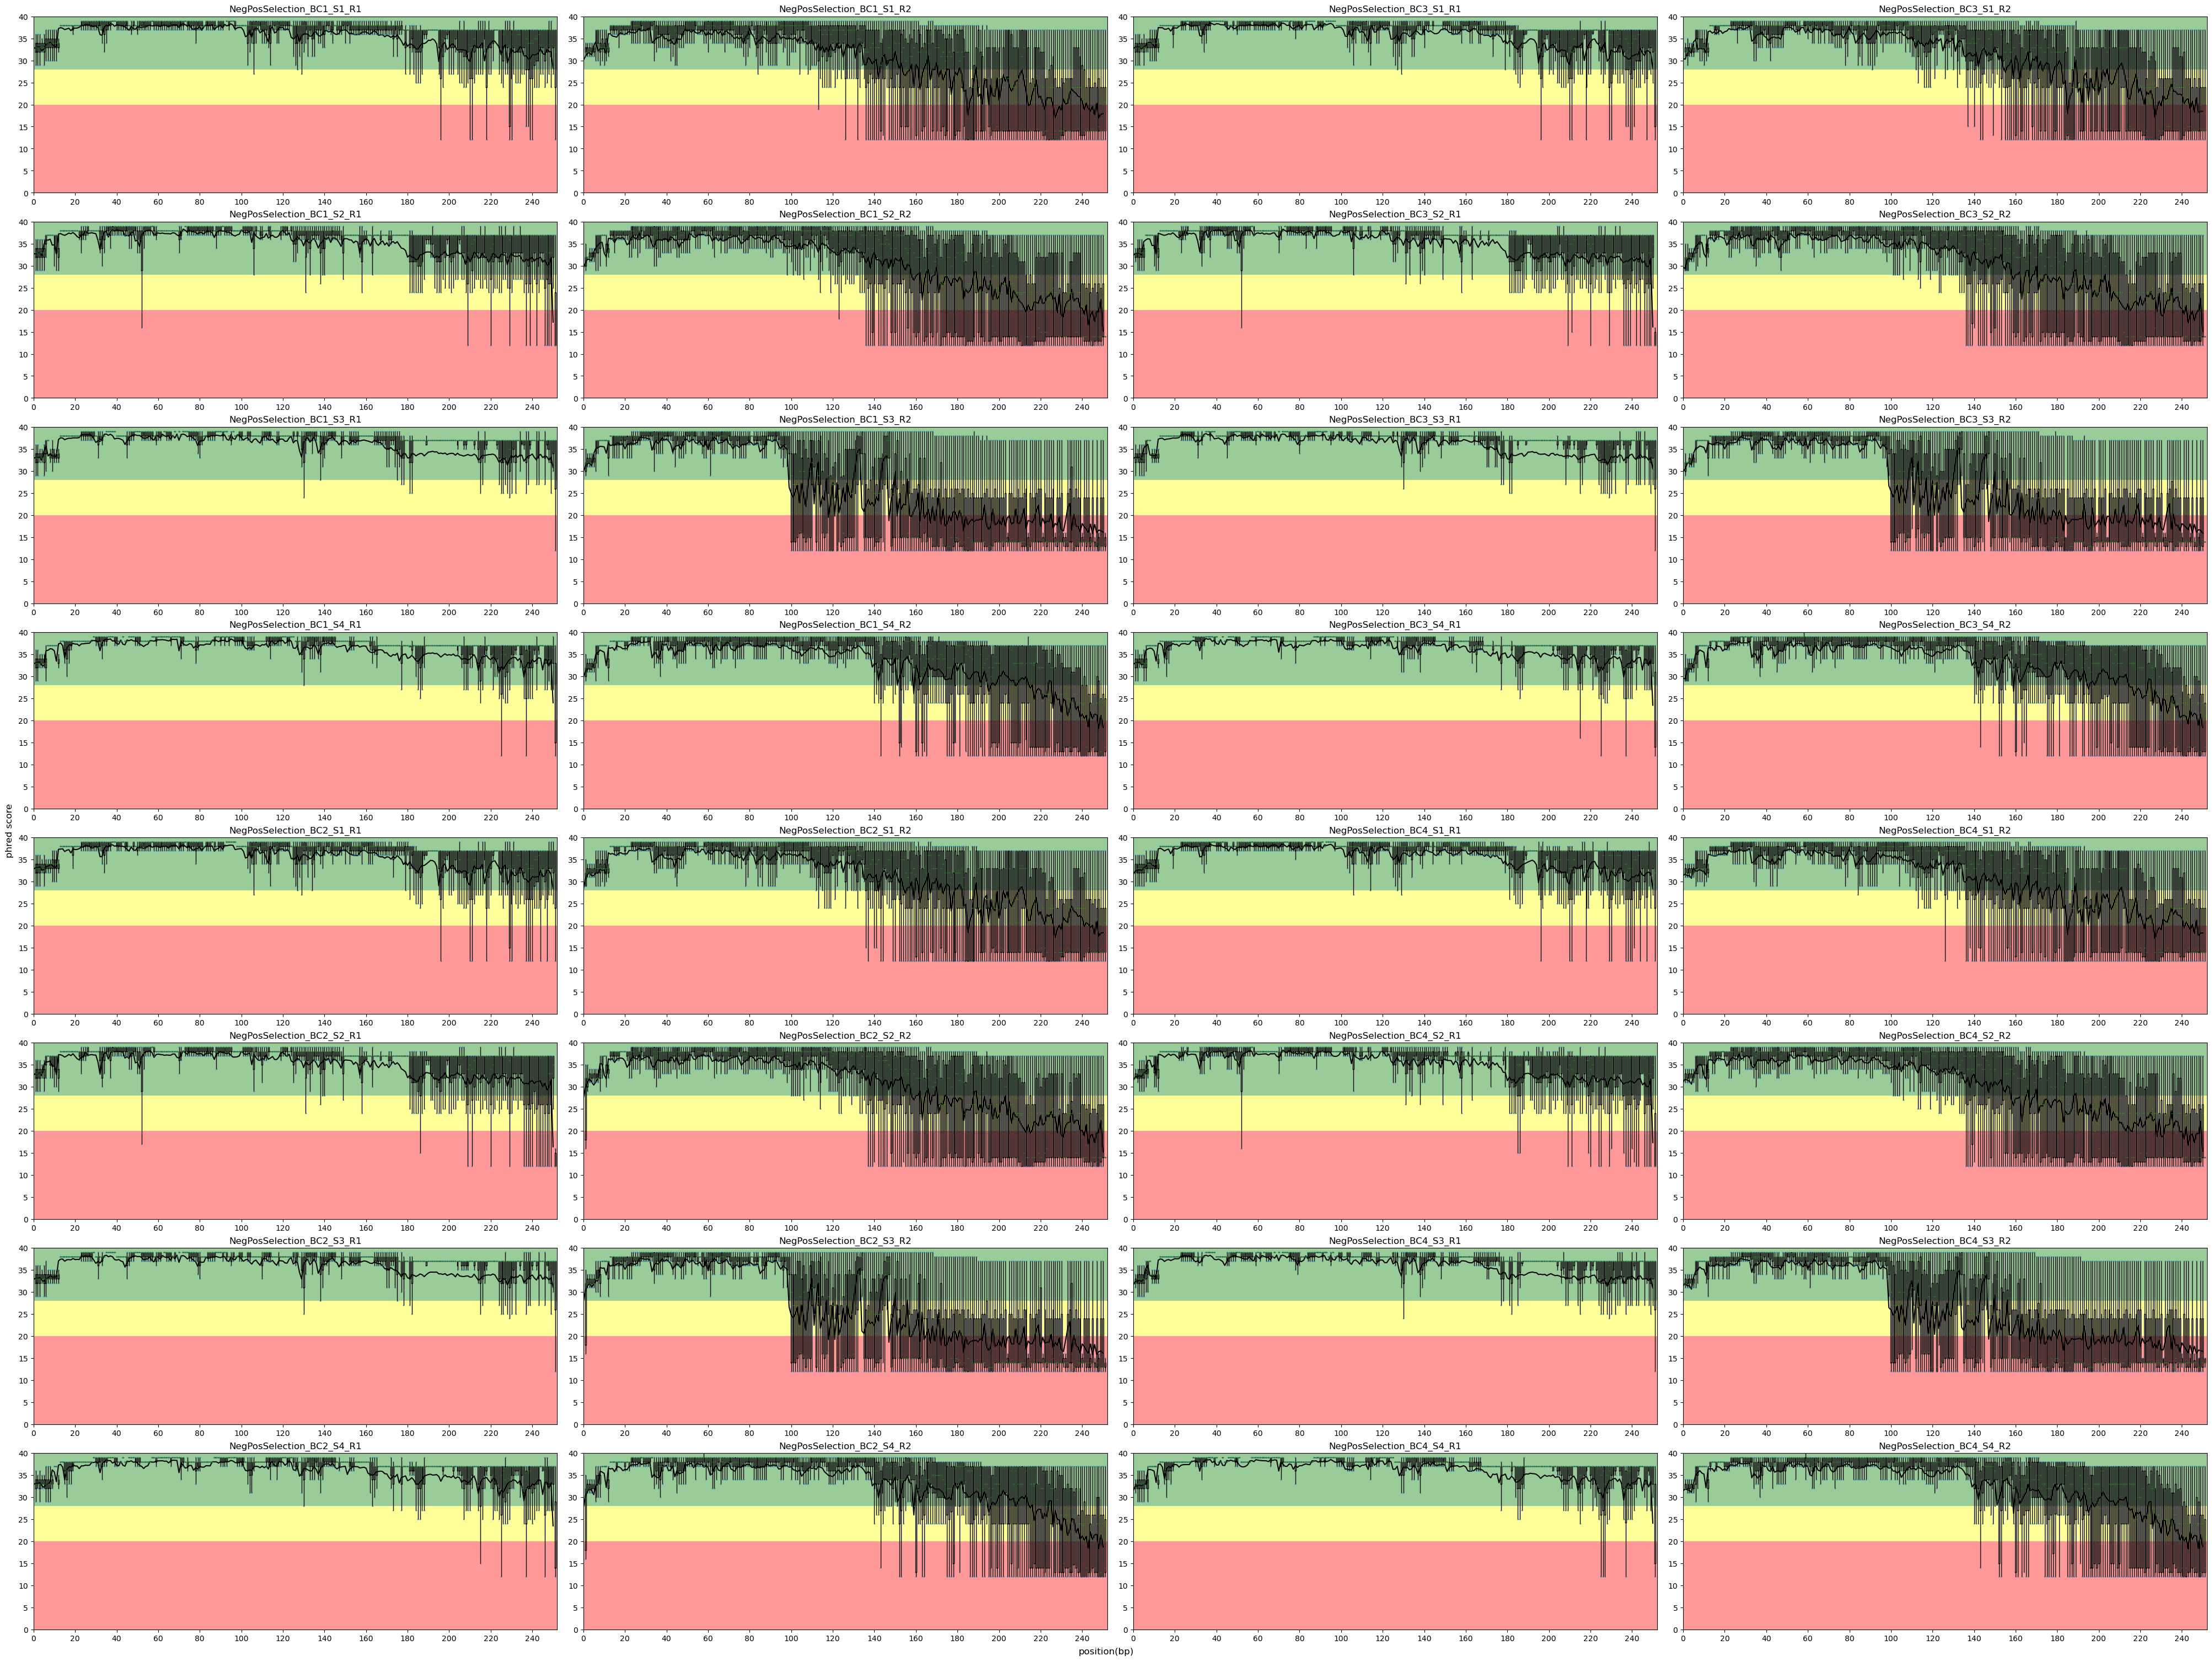

In [186]:
## figure with 4x4 plots of coverages: 

fig, axs = plt.subplots(8, 4, figsize=(40, 30), layout='constrained')
used_Barcodes = ["BC1", "BC2", "BC3", "BC4"]
Sections = ["S1", "S2", "S3", "S4"]
PANCE_step = "NegPosSelection"
read_dirs = ["R1", "R2"]

axis_y = 0
x = 0
for Bc in used_Barcodes: 
    if Bc =="BC3":
        axis_y = 0
        x+=2
    for Section in  Sections:
        
        for read_dir in read_dirs:
            filename = f"{PANCE_step}_{Bc}_{Section}_{read_dir}_001.fastq"

            fastq_parser = SeqIO.parse(filename, "fastq")
            res=[]

            for record in fastq_parser:
                score=record.letter_annotations["phred_quality"]
                res.append(score)
            df = pd.DataFrame(res)
            l = len(df.T)+1
            
            ax = axs[axis_y, read_dirs.index(read_dir)+x]
            
            rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
            ax.add_patch(rect)
            rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
            ax.add_patch(rect)
            rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
            ax.add_patch(rect)
            df.mean().plot(ax=ax,c='black')
            boxprops = dict(linestyle='-', linewidth=1, color='black')
            df.plot(kind='box', ax=ax, grid=False, showfliers=False,
                    color=dict(boxes='black',whiskers='black')  )
            ax.set_xticks(np.arange(0, l, 20))
            ax.set_xticklabels(np.arange(0, l,20))
            
            ax.set_xlim((0,l))
            ax.set_ylim((0,40))
            ax.set_title(filename.split(".")[0][:-4])
        axis_y+=1
    
fig.supxlabel('position(bp)')
fig.supylabel('phred score')
plt.show()

In [154]:
def plot_fastq_qualities(filename, ax=None, limit=10000):

    fastq_parser = SeqIO.parse(filename, "fastq")
    res=[]
    c=0
    for record in fastq_parser:
        score=record.letter_annotations["phred_quality"]
        res.append(score)
        c+=1
        if c>limit:
            break
    df = pd.DataFrame(res)
    l = len(df.T)+1
    
    if ax==None:
        f,ax=plt.subplots(figsize=(12,5))
    rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
    ax.add_patch(rect)
    rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
    ax.add_patch(rect)
    rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
    ax.add_patch(rect)
    df.mean().plot(ax=ax,c='black')
    boxprops = dict(linestyle='-', linewidth=1, color='black')
    df.plot(kind='box', ax=ax, grid=False, showfliers=False,
            color=dict(boxes='black',whiskers='black')  )
    ax.set_xticks(np.arange(0, l, 20))
    ax.set_xticklabels(np.arange(0, l,20))
    ax.set_xlabel('position(bp)')
    ax.set_ylabel('phred score')
    ax.set_xlim((0,l))
    ax.set_ylim((0,40))
    ax.set_title(filename.split(".")[0])    
    

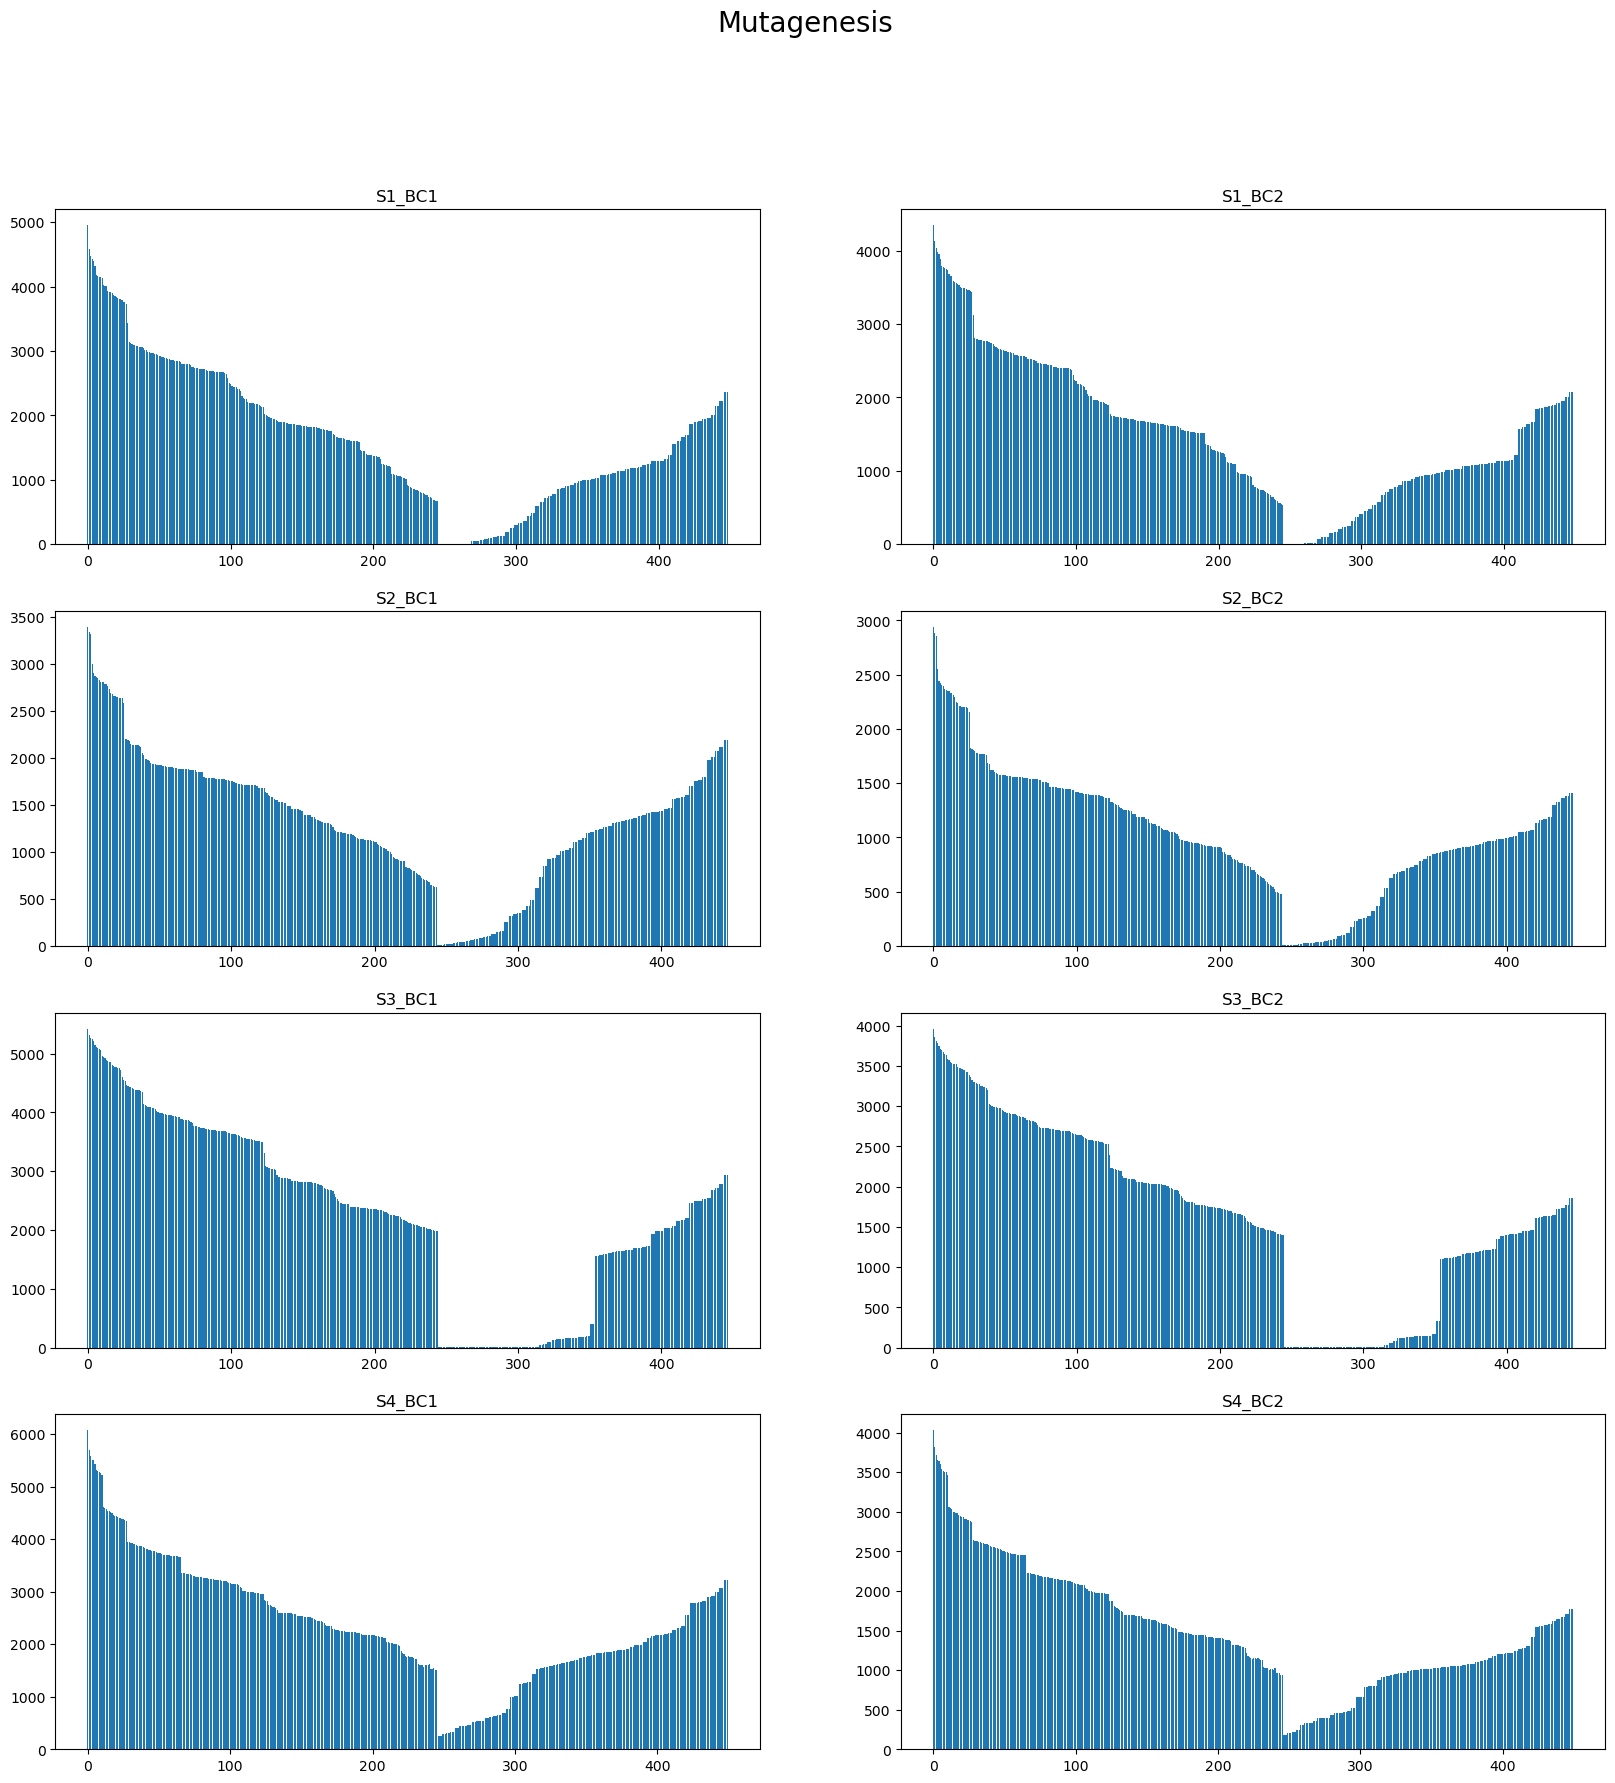

In [141]:
## figure with 4x4 plots of coverages: 

fig, axs = plt.subplots(4, 2, figsize=(20, 20))
used_Barcodes = ["BC1", "BC2"]
Sections = ["S1", "S2", "S3", "S4"]

for Bc in used_Barcodes: 
    for Section in  Sections:
        name = f"{Bc}_{Section}"

        tripl_st = Primer_out_of_triplets[Section+"_fwd_primer"]
        tripl_end = Primer_out_of_triplets[Section+"_rev_primer"]
        ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[Section + "_fwd_primer"][tripl_st:]):ref_gene.index(dna_rev_comp(Primer_seq[Section+"_rev_primer"][tripl_end:]))+len(Primer_seq[Section+"_rev_primer"][tripl_end:])]
        ref_prot_section = translate_dna2aa(ref_seq_Section)

        seq_variants = get_variants(Mutagenesis_reads[f"{Bc}_{Section}_R1"], Mutagenesis_reads[f"{Bc}_{Section}_R2"], catch_left=Barcodes[f"{Bc}_Fwd"]+Primer_seq[Section + "_fwd_primer"][:tripl_st],catch_right=dna_rev_comp(Barcodes[f"{Bc}_Rev"]+Primer_seq[Section+"_rev_primer"][:tripl_end]), ref_prot = ref_prot_section, ref_gene = ref_seq_Section, codons = codons)

        seq_variants["DNA"] = pd.DataFrame.from_dict(seq_variants["DNA"])
        #seq_variants["DNA"] = seq_variants["DNA"].loc[:,seq_variants["DNA"].sum() > 0]
        seq_variants["AA"] = pd.DataFrame.from_dict(seq_variants["AA"])
        #seq_variants["AA"] = seq_variants["AA"].loc[:,seq_variants["AA"].sum() > 0]
        seq_variants["Codons"] = pd.DataFrame.from_dict(seq_variants["Codons"])
        #seq_variants["Codons"] = seq_variants["Codons"].loc[:,seq_variants["Codons"].sum() > 0]

        ax = axs[Sections.index(Section), used_Barcodes.index(Bc)]
        ax.bar(seq_variants["DNA"].sum().index, seq_variants["DNA"].sum())
        ax.set_title(f'{Section}_{Bc}')
    
fig.suptitle("Mutagenesis", fontsize = 20)                                                                  
plt.show()

In [190]:

### calculate sum of single, double and triple mutants
def gather_n_mutations(a_seq, b_seq, reference_seq,catch_left, catch_right, use_backward_read = True, use_forward_read = True, use_triplets = False):
    """
    returns a dictionary with the number of single, double, triple (...) mutants
    a_seq, b_seq = list of sequences
    """
    mutation_dict = {}
    catch_length = len(catch_left)    
    
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        if use_forward_read and catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            if use_triplets: 
                n_muts_a_seq = sum([reference_seq[i:i+3] != gene_a[i:i+3] for i in range(0,len(gene_a)//3*3,3)])
            else: 
                n_muts_a_seq = sum([reference_seq[i] != gene_a[i] for i in range(len(gene_a))])

        else: n_muts_a_seq = 0
            
        if use_backward_read and dna_rev_comp(catch_right) in b_seq:
                index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
                gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
                gene_b = gene_b[::-1]
                n_muts_b_seq = sum([reference_seq[::-1][i] != gene_b[i] for i in range(len(gene_b))])
                
        else: n_muts_b_seq = 0

        n_muts = n_muts_a_seq + n_muts_b_seq

        if n_muts in mutation_dict:
            mutation_dict[n_muts] += 1
        else:
            mutation_dict[n_muts] = 1

    return mutation_dict

In [192]:
Barcodes

{'BC1_Fwd': 'AAGG',
 'BC1_Rev': 'ATCA',
 'BC2_Fwd': 'AGTC',
 'BC2_Rev': 'GCCG',
 'BC3_Fwd': 'AGGA',
 'BC3_Rev': 'AATT',
 'BC4_Fwd': 'GCGA',
 'BC4_Rev': 'TGGT'}

Nt mutations {0: 10755, 1: 140, 2: 66, 3: 56, 4: 26, 5: 141, 6: 69, 7: 23, 8: 29, 9: 271, 10: 59, 11: 17, 12: 35, 13: 53, 14: 11, 15: 31, 16: 89, 17: 32, 18: 1409, 19: 66, 20: 127, 21: 231, 22: 40, 23: 29, 24: 160, 25: 13, 26: 51, 27: 61, 28: 121, 29: 18, 30: 60, 31: 22, 32: 107, 33: 40, 34: 52, 35: 20, 36: 39, 37: 32, 38: 55, 39: 41, 40: 97, 41: 39, 42: 31, 43: 25, 44: 484, 45: 28, 46: 4, 47: 5, 48: 9, 49: 158, 50: 4, 51: 9, 52: 6, 53: 5, 54: 17, 55: 24, 56: 15, 57: 9, 58: 11, 59: 11, 60: 9, 61: 7, 62: 21, 63: 5, 64: 7, 65: 5, 66: 8, 67: 10, 68: 8, 69: 5, 70: 2, 71: 8, 72: 6, 73: 8, 74: 6, 75: 5, 76: 15, 77: 37, 78: 12, 79: 14, 80: 5, 81: 14, 82: 10, 83: 29, 84: 20, 85: 10, 86: 15, 87: 3, 88: 11, 89: 16, 90: 22, 91: 274, 92: 10, 93: 9, 94: 3, 95: 54, 96: 17, 97: 67, 98: 45, 99: 25, 100: 46, 101: 23, 102: 79, 103: 79, 104: 27, 105: 18, 106: 11, 107: 17, 108: 22, 109: 90, 110: 31, 111: 10, 112: 4, 113: 27, 114: 8, 115: 33, 116: 18, 117: 16, 118: 127, 119: 31, 120: 48, 121: 23, 122: 18, 

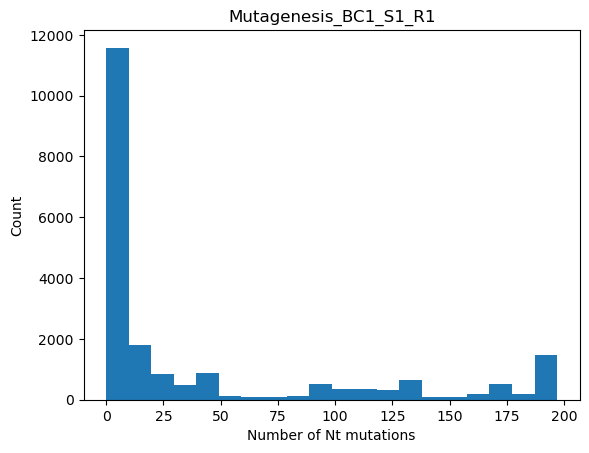

Nt mutations {0: 10815, 1: 265, 2: 68, 3: 54, 4: 55, 5: 34, 6: 67, 7: 266, 8: 30, 9: 17, 10: 56, 11: 32, 12: 43, 13: 40, 14: 30, 15: 22, 16: 82, 17: 1320, 18: 74, 19: 140, 20: 36, 21: 332, 22: 57, 23: 52, 24: 44, 25: 41, 26: 74, 27: 84, 28: 19, 29: 41, 30: 45, 31: 32, 32: 22, 33: 25, 34: 42, 35: 103, 36: 49, 37: 25, 38: 49, 39: 28, 40: 108, 41: 17, 42: 49, 43: 464, 44: 18, 45: 160, 46: 7, 47: 10, 48: 6, 49: 6, 50: 19, 51: 16, 52: 22, 53: 37, 54: 17, 55: 7, 56: 8, 57: 5, 58: 5, 59: 12, 60: 30, 61: 7, 62: 8, 63: 14, 64: 8, 65: 4, 66: 5, 67: 5, 68: 1, 69: 4, 70: 8, 71: 9, 72: 8, 73: 6, 74: 18, 75: 21, 76: 39, 77: 22, 78: 22, 79: 18, 80: 6, 81: 27, 82: 13, 83: 17, 84: 28, 85: 26, 86: 33, 87: 11, 88: 54, 89: 27, 90: 23, 91: 29, 92: 30, 93: 106, 94: 26, 95: 50, 96: 12, 97: 29, 98: 99, 99: 176, 100: 33, 101: 14, 102: 11, 103: 47, 104: 56, 105: 28, 106: 13, 107: 24, 108: 19, 109: 12, 110: 83, 111: 18, 112: 9, 113: 3, 114: 11, 115: 8, 116: 52, 117: 20, 118: 136, 119: 26, 120: 20, 121: 24, 122: 

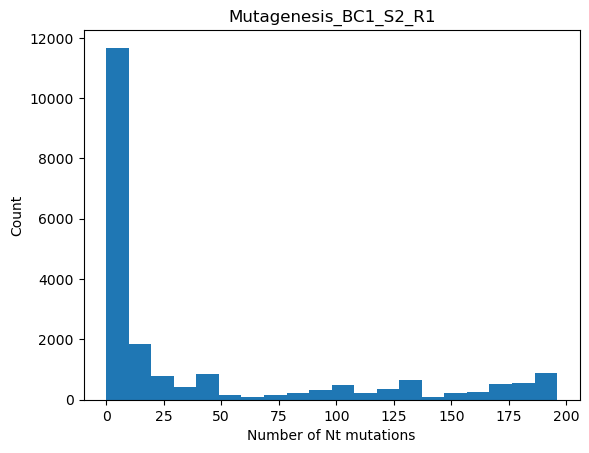

Nt mutations {0: 11244, 1: 208, 2: 91, 3: 60, 4: 127, 5: 115, 6: 24, 7: 47, 8: 32, 9: 257, 10: 51, 11: 18, 12: 60, 13: 36, 14: 62, 15: 106, 16: 36, 17: 108, 18: 1325, 19: 114, 20: 23, 21: 223, 22: 175, 23: 72, 24: 239, 25: 39, 26: 16, 27: 58, 28: 27, 29: 34, 30: 43, 31: 61, 32: 33, 33: 507, 34: 31, 35: 57, 36: 118, 37: 19, 38: 14, 39: 28, 40: 17, 41: 9, 42: 5, 43: 7, 44: 12, 45: 14, 46: 4, 47: 3, 48: 4, 49: 7, 50: 36, 51: 9, 52: 155, 53: 14, 54: 24, 55: 9, 56: 24, 57: 24, 58: 25, 59: 16, 60: 5, 61: 6, 62: 9, 63: 13, 64: 6, 65: 4, 66: 5, 67: 21, 68: 5, 69: 3, 70: 6, 71: 23, 72: 40, 73: 30, 74: 7, 75: 25, 76: 19, 77: 28, 78: 37, 79: 16, 80: 10, 81: 9, 82: 17, 83: 26, 84: 35, 85: 10, 86: 20, 87: 8, 88: 115, 89: 12, 90: 38, 91: 73, 92: 11, 93: 6, 94: 28, 95: 48, 96: 20, 97: 27, 98: 52, 99: 86, 100: 36, 101: 10, 102: 30, 103: 18, 104: 19, 105: 10, 106: 103, 107: 9, 108: 5, 109: 10, 110: 10, 111: 51, 112: 160, 113: 23, 114: 10, 115: 3, 116: 8, 117: 25, 118: 38, 119: 24, 120: 32, 121: 28, 122

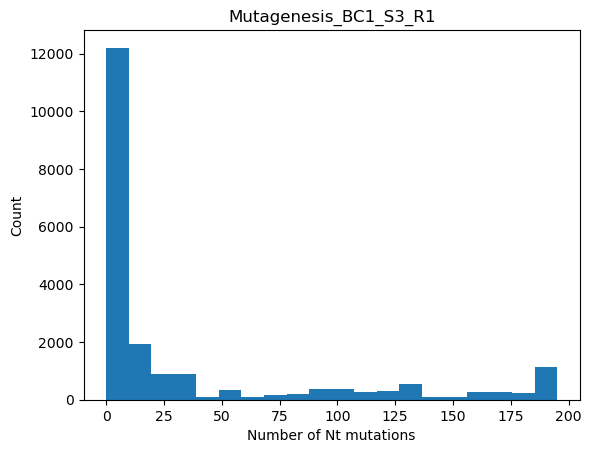

Nt mutations {0: 11109, 1: 244, 2: 90, 3: 117, 4: 76, 5: 59, 6: 48, 7: 22, 8: 26, 9: 60, 10: 58, 11: 52, 12: 35, 13: 61, 14: 40, 15: 24, 16: 34, 17: 45, 18: 59, 19: 264, 20: 1378, 21: 181, 22: 15, 23: 27, 24: 232, 25: 41, 26: 136, 27: 82, 28: 50, 29: 37, 30: 18, 31: 31, 32: 26, 33: 98, 34: 35, 35: 45, 36: 140, 37: 39, 38: 49, 39: 32, 40: 22, 41: 58, 42: 462, 43: 17, 44: 4, 45: 22, 46: 12, 47: 14, 48: 9, 49: 12, 50: 3, 51: 7, 52: 12, 53: 11, 54: 18, 55: 10, 56: 4, 57: 11, 58: 52, 59: 9, 60: 3, 61: 12, 62: 10, 63: 26, 64: 13, 65: 9, 66: 6, 67: 3, 68: 3, 69: 8, 70: 6, 72: 6, 73: 26, 74: 9, 75: 12, 76: 7, 77: 85, 78: 9, 79: 8, 80: 8, 81: 12, 82: 19, 83: 39, 84: 26, 85: 13, 86: 16, 87: 35, 88: 102, 89: 28, 90: 37, 91: 31, 92: 16, 93: 31, 94: 56, 95: 208, 96: 12, 97: 75, 98: 57, 99: 64, 100: 21, 101: 11, 102: 29, 103: 22, 104: 13, 105: 90, 106: 15, 107: 11, 108: 16, 109: 20, 110: 6, 111: 36, 112: 30, 113: 113, 114: 32, 115: 11, 116: 26, 117: 12, 118: 8, 119: 17, 120: 19, 121: 22, 122: 36, 12

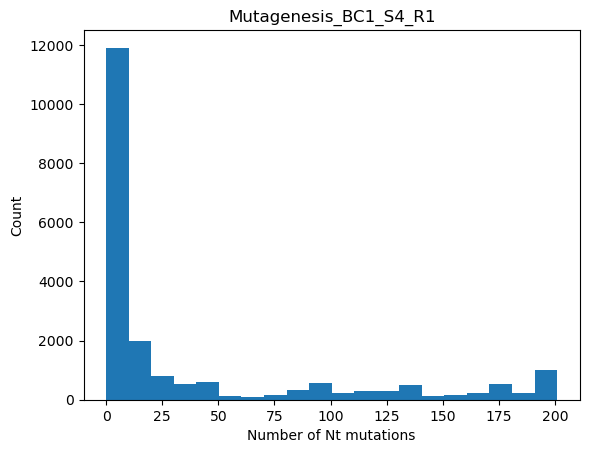

Nt mutations {0: 12636, 1: 113, 2: 39, 3: 56, 4: 37, 5: 168, 6: 57, 7: 33, 8: 18, 9: 255, 10: 35, 11: 94, 12: 24, 13: 40, 14: 39, 15: 48, 16: 56, 17: 20, 18: 20, 19: 12, 20: 44, 21: 215, 22: 14, 23: 14, 24: 157, 25: 81, 26: 20, 27: 21, 28: 66, 29: 23, 30: 49, 31: 15, 32: 78, 33: 33, 34: 47, 35: 185, 36: 35, 37: 20, 38: 15, 39: 19, 40: 15, 41: 18, 42: 13, 43: 16, 44: 10, 45: 3, 46: 11, 47: 8, 48: 11, 49: 136, 50: 13, 51: 10, 52: 19, 53: 22, 54: 32, 55: 15, 56: 17, 57: 7, 58: 12, 59: 12, 60: 9, 61: 11, 62: 29, 63: 19, 64: 3, 65: 13, 66: 13, 67: 5, 68: 4, 69: 12, 70: 8, 71: 12, 72: 15, 73: 7, 74: 10, 75: 23, 76: 28, 77: 15, 78: 33, 79: 39, 80: 791, 81: 40, 82: 9, 83: 45, 84: 16, 85: 11, 86: 8, 87: 6, 88: 9, 89: 70, 90: 75, 91: 181, 92: 10, 93: 9, 94: 14, 95: 16, 96: 9, 97: 88, 98: 20, 99: 22, 100: 23, 101: 20, 102: 42, 103: 26, 104: 25, 105: 15, 106: 10, 107: 8, 108: 16, 109: 19, 110: 17, 111: 3, 112: 3, 113: 24, 114: 7, 115: 2, 116: 10, 117: 13, 118: 7, 119: 7, 120: 33, 121: 22, 122: 20,

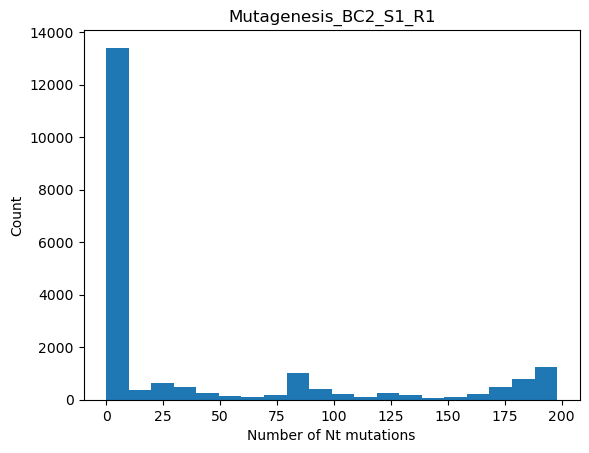

Nt mutations {0: 12578, 1: 215, 2: 87, 3: 27, 4: 62, 5: 39, 6: 73, 7: 228, 8: 30, 9: 31, 10: 103, 11: 14, 12: 34, 13: 29, 14: 7, 15: 18, 16: 36, 17: 64, 18: 19, 19: 122, 20: 21, 21: 245, 22: 21, 23: 35, 24: 26, 25: 14, 26: 14, 27: 19, 28: 21, 29: 80, 30: 32, 31: 30, 32: 31, 33: 30, 34: 44, 35: 164, 36: 92, 37: 48, 38: 13, 39: 10, 40: 8, 41: 7, 42: 20, 43: 18, 44: 12, 45: 149, 46: 16, 47: 16, 48: 13, 49: 7, 50: 20, 51: 13, 52: 19, 53: 28, 54: 29, 55: 27, 56: 34, 57: 13, 58: 1, 59: 17, 60: 22, 61: 14, 62: 9, 63: 22, 64: 7, 65: 9, 66: 11, 67: 9, 68: 8, 69: 13, 70: 7, 71: 6, 72: 37, 73: 823, 74: 50, 75: 35, 76: 29, 77: 25, 78: 16, 79: 14, 80: 9, 81: 11, 82: 16, 83: 7, 84: 29, 85: 37, 86: 25, 87: 18, 88: 46, 89: 21, 90: 29, 91: 23, 92: 79, 93: 85, 94: 20, 95: 15, 96: 11, 97: 27, 98: 88, 99: 135, 100: 41, 101: 29, 102: 5, 103: 17, 104: 4, 105: 19, 106: 5, 107: 7, 108: 7, 109: 5, 110: 8, 111: 7, 112: 10, 113: 9, 114: 6, 115: 9, 116: 8, 117: 18, 118: 12, 119: 20, 120: 21, 121: 37, 122: 7, 123:

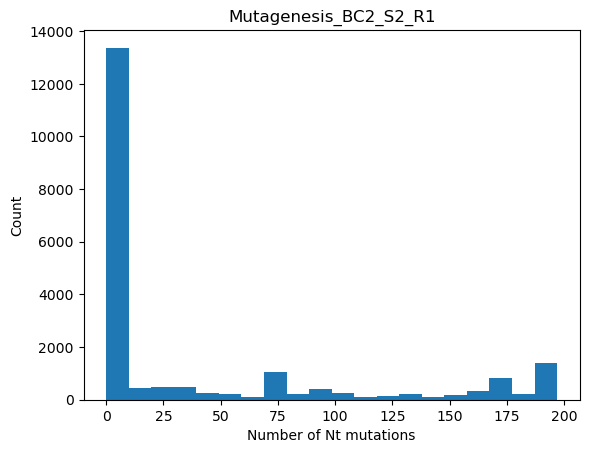

Nt mutations {0: 12879, 1: 192, 2: 69, 3: 68, 4: 127, 5: 91, 6: 22, 7: 33, 8: 11, 9: 255, 10: 133, 11: 19, 12: 20, 13: 40, 14: 8, 15: 17, 16: 33, 17: 44, 18: 27, 19: 32, 20: 15, 21: 207, 22: 136, 23: 13, 24: 208, 25: 12, 26: 25, 27: 38, 28: 35, 29: 86, 30: 17, 31: 127, 32: 69, 33: 40, 34: 24, 35: 56, 36: 45, 37: 28, 38: 18, 39: 29, 40: 14, 41: 17, 42: 11, 43: 8, 44: 10, 45: 13, 46: 13, 47: 10, 48: 8, 49: 7, 50: 32, 51: 23, 52: 155, 53: 21, 54: 30, 55: 10, 56: 25, 57: 33, 58: 22, 59: 17, 60: 10, 61: 14, 62: 31, 63: 13, 64: 12, 65: 5, 66: 3, 67: 14, 68: 9, 69: 13, 70: 7, 71: 25, 72: 46, 73: 10, 74: 8, 75: 14, 76: 22, 77: 16, 78: 56, 79: 24, 80: 7, 81: 1, 82: 68, 83: 799, 84: 36, 85: 40, 86: 10, 87: 12, 88: 20, 89: 29, 90: 6, 91: 49, 92: 12, 93: 52, 94: 76, 95: 51, 96: 16, 97: 27, 98: 32, 99: 11, 100: 31, 101: 17, 102: 31, 103: 22, 104: 11, 105: 12, 106: 4, 107: 5, 108: 4, 109: 10, 110: 3, 111: 27, 112: 13, 113: 15, 114: 10, 115: 3, 116: 4, 117: 12, 118: 5, 119: 16, 120: 3, 121: 13, 122: 

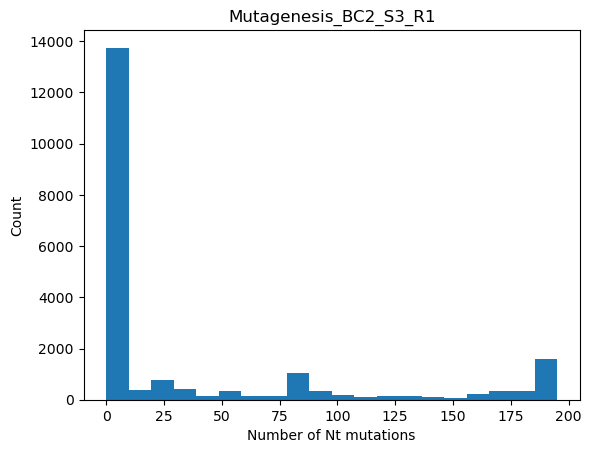

Nt mutations {0: 12891, 1: 233, 2: 92, 3: 128, 4: 85, 5: 64, 6: 30, 7: 26, 8: 98, 9: 47, 10: 29, 11: 35, 12: 29, 13: 61, 14: 14, 15: 24, 16: 19, 17: 21, 18: 49, 19: 219, 20: 29, 21: 51, 22: 19, 23: 12, 24: 208, 25: 18, 26: 47, 27: 72, 28: 25, 29: 44, 30: 93, 31: 81, 32: 100, 33: 93, 34: 18, 35: 21, 36: 35, 37: 6, 38: 19, 39: 23, 40: 13, 41: 28, 42: 16, 43: 1, 44: 8, 45: 21, 46: 18, 47: 17, 48: 14, 49: 8, 50: 6, 51: 5, 52: 8, 53: 14, 54: 29, 55: 21, 56: 7, 57: 19, 58: 50, 59: 12, 60: 31, 61: 10, 62: 14, 63: 20, 64: 26, 65: 8, 66: 7, 67: 16, 68: 7, 69: 6, 70: 9, 71: 5, 72: 1, 73: 12, 74: 14, 75: 6, 76: 17, 77: 75, 78: 814, 79: 42, 80: 8, 81: 19, 82: 47, 83: 64, 84: 31, 85: 9, 86: 8, 87: 23, 88: 10, 89: 21, 90: 2, 91: 22, 92: 13, 93: 62, 94: 103, 95: 190, 96: 16, 97: 62, 98: 25, 99: 16, 100: 15, 101: 16, 102: 24, 103: 10, 104: 10, 105: 12, 106: 3, 107: 14, 108: 15, 109: 14, 110: 1, 111: 4, 112: 19, 113: 11, 114: 10, 115: 6, 116: 4, 117: 5, 118: 5, 119: 6, 120: 4, 121: 11, 122: 15, 123: 25

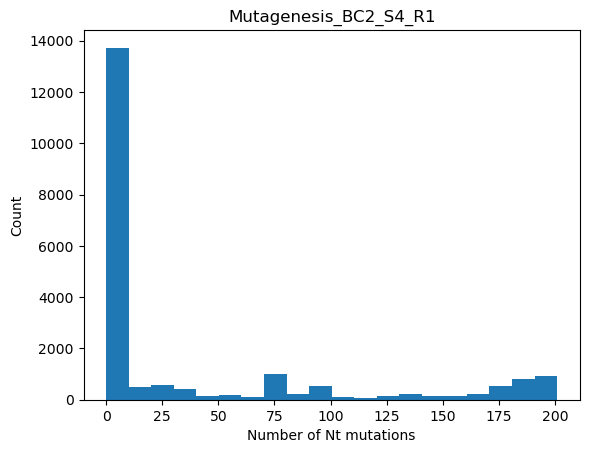

<Figure size 640x480 with 0 Axes>

In [202]:

Step ="Mutagenesis"
used_Barcodes = ["BC1", "BC2"]
Section = "S1"
for Bc in used_Barcodes:
    for Section in Sections: 
        a_reads = all_reads[f"{Step}_{Bc}_{Section}_R1"]
        b_reads = all_reads[f"{Step}_{Bc}_{Section}_R2"]
        ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[f"{Section}_fwd_primer"]):ref_gene.index(dna_rev_comp(Primer_seq[f"{Section}_rev_primer"]))+len(Primer_seq[f"{Section}_rev_primer"])]
        ## calculate and plot the number of Nt and Codon mutations per sequence

        seq_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, catch_left=Barcodes[f"{Bc}_Fwd"],catch_right=[f"{Bc}_Rev"],  reference_seq = ref_seq_Section, use_backward_read=False, use_triplets=False)
        seq_n_Nt_mutations = dict(sorted(seq_n_Nt_mutations.items())) ## sort dictionary after key

        #seq_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True, treshold = treshold)
        #seq_n_Codon_mutations = dict(sorted(seq_n_Codon_mutations.items())) ## sort dictionary after key

        print("Nt mutations", seq_n_Nt_mutations)
        #print("Codon mutations", seq_n_Codon_mutations)
        plt.hist(seq_n_Nt_mutations.keys(), weights=seq_n_Nt_mutations.values(), bins = 20)
        plt.xlabel("Number of Nt mutations")
        plt.ylabel("Count")
        plt.title(f"{Step}_{Bc}_{Section}_R1")
        plt.show()
        plt.clf()

Nt mutations {0: 10755, 1: 140, 2: 66, 3: 56, 4: 26, 5: 141, 6: 69, 7: 23, 8: 29, 9: 271, 10: 59, 11: 17, 12: 35, 13: 53, 14: 11, 15: 31, 16: 89, 17: 32, 18: 1409, 19: 66, 20: 127, 21: 231, 22: 40, 23: 29, 24: 160, 25: 13, 26: 51, 27: 61, 28: 121, 29: 18, 30: 60, 31: 22, 32: 107, 33: 40, 34: 52, 35: 20, 36: 39, 37: 32, 38: 55, 39: 41, 40: 97, 41: 39, 42: 31, 43: 25, 44: 484, 45: 28, 46: 4, 47: 5, 48: 9, 49: 158, 50: 4, 51: 9, 52: 6, 53: 5, 54: 17, 55: 24, 56: 15, 57: 9, 58: 11, 59: 11, 60: 9, 61: 7, 62: 21, 63: 5, 64: 7, 65: 5, 66: 8, 67: 10, 68: 8, 69: 5, 70: 2, 71: 8, 72: 6, 73: 8, 74: 6, 75: 5, 76: 15, 77: 37, 78: 12, 79: 14, 80: 5, 81: 14, 82: 10, 83: 29, 84: 20, 85: 10, 86: 15, 87: 3, 88: 11, 89: 16, 90: 22, 91: 274, 92: 10, 93: 9, 94: 3, 95: 54, 96: 17, 97: 67, 98: 45, 99: 25, 100: 46, 101: 23, 102: 79, 103: 79, 104: 27, 105: 18, 106: 11, 107: 17, 108: 22, 109: 90, 110: 31, 111: 10, 112: 4, 113: 27, 114: 8, 115: 33, 116: 18, 117: 16, 118: 127, 119: 31, 120: 48, 121: 23, 122: 18, 

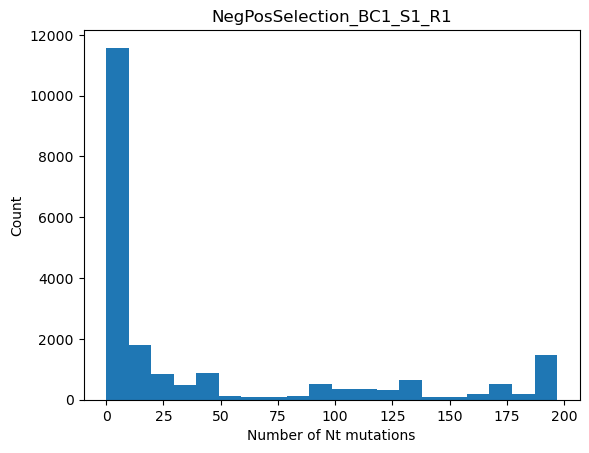

Nt mutations {0: 10815, 1: 265, 2: 68, 3: 54, 4: 55, 5: 34, 6: 67, 7: 266, 8: 30, 9: 17, 10: 56, 11: 32, 12: 43, 13: 40, 14: 30, 15: 22, 16: 82, 17: 1320, 18: 74, 19: 140, 20: 36, 21: 332, 22: 57, 23: 52, 24: 44, 25: 41, 26: 74, 27: 84, 28: 19, 29: 41, 30: 45, 31: 32, 32: 22, 33: 25, 34: 42, 35: 103, 36: 49, 37: 25, 38: 49, 39: 28, 40: 108, 41: 17, 42: 49, 43: 464, 44: 18, 45: 160, 46: 7, 47: 10, 48: 6, 49: 6, 50: 19, 51: 16, 52: 22, 53: 37, 54: 17, 55: 7, 56: 8, 57: 5, 58: 5, 59: 12, 60: 30, 61: 7, 62: 8, 63: 14, 64: 8, 65: 4, 66: 5, 67: 5, 68: 1, 69: 4, 70: 8, 71: 9, 72: 8, 73: 6, 74: 18, 75: 21, 76: 39, 77: 22, 78: 22, 79: 18, 80: 6, 81: 27, 82: 13, 83: 17, 84: 28, 85: 26, 86: 33, 87: 11, 88: 54, 89: 27, 90: 23, 91: 29, 92: 30, 93: 106, 94: 26, 95: 50, 96: 12, 97: 29, 98: 99, 99: 176, 100: 33, 101: 14, 102: 11, 103: 47, 104: 56, 105: 28, 106: 13, 107: 24, 108: 19, 109: 12, 110: 83, 111: 18, 112: 9, 113: 3, 114: 11, 115: 8, 116: 52, 117: 20, 118: 136, 119: 26, 120: 20, 121: 24, 122: 

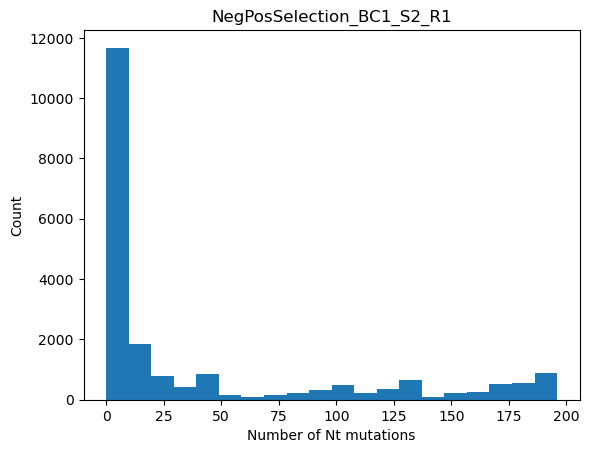

Nt mutations {0: 11244, 1: 208, 2: 91, 3: 60, 4: 127, 5: 115, 6: 24, 7: 47, 8: 32, 9: 257, 10: 51, 11: 18, 12: 60, 13: 36, 14: 62, 15: 106, 16: 36, 17: 108, 18: 1325, 19: 114, 20: 23, 21: 223, 22: 175, 23: 72, 24: 239, 25: 39, 26: 16, 27: 58, 28: 27, 29: 34, 30: 43, 31: 61, 32: 33, 33: 507, 34: 31, 35: 57, 36: 118, 37: 19, 38: 14, 39: 28, 40: 17, 41: 9, 42: 5, 43: 7, 44: 12, 45: 14, 46: 4, 47: 3, 48: 4, 49: 7, 50: 36, 51: 9, 52: 155, 53: 14, 54: 24, 55: 9, 56: 24, 57: 24, 58: 25, 59: 16, 60: 5, 61: 6, 62: 9, 63: 13, 64: 6, 65: 4, 66: 5, 67: 21, 68: 5, 69: 3, 70: 6, 71: 23, 72: 40, 73: 30, 74: 7, 75: 25, 76: 19, 77: 28, 78: 37, 79: 16, 80: 10, 81: 9, 82: 17, 83: 26, 84: 35, 85: 10, 86: 20, 87: 8, 88: 115, 89: 12, 90: 38, 91: 73, 92: 11, 93: 6, 94: 28, 95: 48, 96: 20, 97: 27, 98: 52, 99: 86, 100: 36, 101: 10, 102: 30, 103: 18, 104: 19, 105: 10, 106: 103, 107: 9, 108: 5, 109: 10, 110: 10, 111: 51, 112: 160, 113: 23, 114: 10, 115: 3, 116: 8, 117: 25, 118: 38, 119: 24, 120: 32, 121: 28, 122

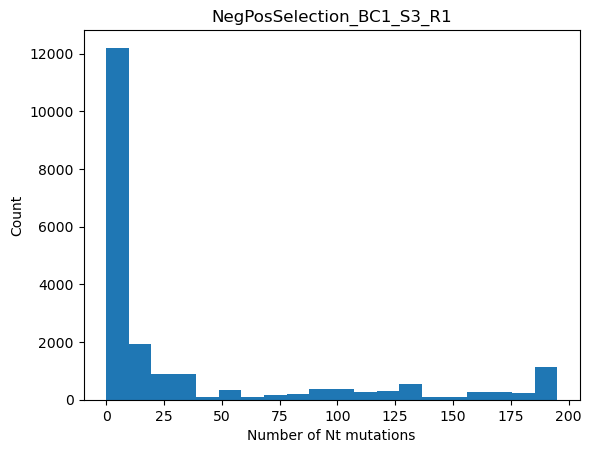

Nt mutations {0: 11109, 1: 244, 2: 90, 3: 117, 4: 76, 5: 59, 6: 48, 7: 22, 8: 26, 9: 60, 10: 58, 11: 52, 12: 35, 13: 61, 14: 40, 15: 24, 16: 34, 17: 45, 18: 59, 19: 264, 20: 1378, 21: 181, 22: 15, 23: 27, 24: 232, 25: 41, 26: 136, 27: 82, 28: 50, 29: 37, 30: 18, 31: 31, 32: 26, 33: 98, 34: 35, 35: 45, 36: 140, 37: 39, 38: 49, 39: 32, 40: 22, 41: 58, 42: 462, 43: 17, 44: 4, 45: 22, 46: 12, 47: 14, 48: 9, 49: 12, 50: 3, 51: 7, 52: 12, 53: 11, 54: 18, 55: 10, 56: 4, 57: 11, 58: 52, 59: 9, 60: 3, 61: 12, 62: 10, 63: 26, 64: 13, 65: 9, 66: 6, 67: 3, 68: 3, 69: 8, 70: 6, 72: 6, 73: 26, 74: 9, 75: 12, 76: 7, 77: 85, 78: 9, 79: 8, 80: 8, 81: 12, 82: 19, 83: 39, 84: 26, 85: 13, 86: 16, 87: 35, 88: 102, 89: 28, 90: 37, 91: 31, 92: 16, 93: 31, 94: 56, 95: 208, 96: 12, 97: 75, 98: 57, 99: 64, 100: 21, 101: 11, 102: 29, 103: 22, 104: 13, 105: 90, 106: 15, 107: 11, 108: 16, 109: 20, 110: 6, 111: 36, 112: 30, 113: 113, 114: 32, 115: 11, 116: 26, 117: 12, 118: 8, 119: 17, 120: 19, 121: 22, 122: 36, 12

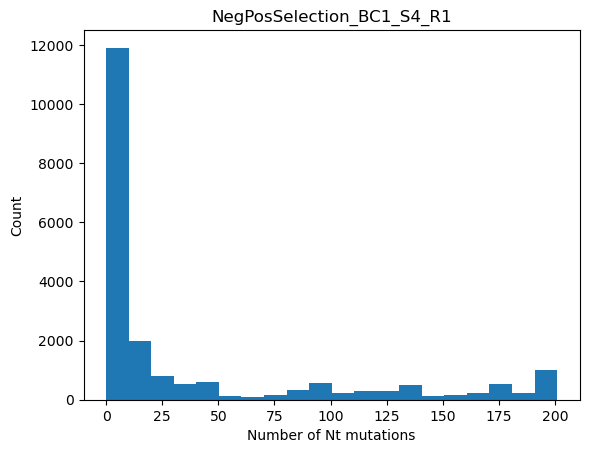

Nt mutations {0: 12636, 1: 113, 2: 39, 3: 56, 4: 37, 5: 168, 6: 57, 7: 33, 8: 18, 9: 255, 10: 35, 11: 94, 12: 24, 13: 40, 14: 39, 15: 48, 16: 56, 17: 20, 18: 20, 19: 12, 20: 44, 21: 215, 22: 14, 23: 14, 24: 157, 25: 81, 26: 20, 27: 21, 28: 66, 29: 23, 30: 49, 31: 15, 32: 78, 33: 33, 34: 47, 35: 185, 36: 35, 37: 20, 38: 15, 39: 19, 40: 15, 41: 18, 42: 13, 43: 16, 44: 10, 45: 3, 46: 11, 47: 8, 48: 11, 49: 136, 50: 13, 51: 10, 52: 19, 53: 22, 54: 32, 55: 15, 56: 17, 57: 7, 58: 12, 59: 12, 60: 9, 61: 11, 62: 29, 63: 19, 64: 3, 65: 13, 66: 13, 67: 5, 68: 4, 69: 12, 70: 8, 71: 12, 72: 15, 73: 7, 74: 10, 75: 23, 76: 28, 77: 15, 78: 33, 79: 39, 80: 791, 81: 40, 82: 9, 83: 45, 84: 16, 85: 11, 86: 8, 87: 6, 88: 9, 89: 70, 90: 75, 91: 181, 92: 10, 93: 9, 94: 14, 95: 16, 96: 9, 97: 88, 98: 20, 99: 22, 100: 23, 101: 20, 102: 42, 103: 26, 104: 25, 105: 15, 106: 10, 107: 8, 108: 16, 109: 19, 110: 17, 111: 3, 112: 3, 113: 24, 114: 7, 115: 2, 116: 10, 117: 13, 118: 7, 119: 7, 120: 33, 121: 22, 122: 20,

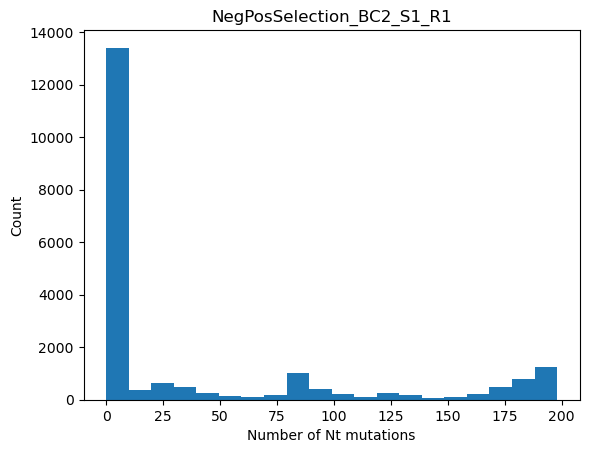

Nt mutations {0: 12578, 1: 215, 2: 87, 3: 27, 4: 62, 5: 39, 6: 73, 7: 228, 8: 30, 9: 31, 10: 103, 11: 14, 12: 34, 13: 29, 14: 7, 15: 18, 16: 36, 17: 64, 18: 19, 19: 122, 20: 21, 21: 245, 22: 21, 23: 35, 24: 26, 25: 14, 26: 14, 27: 19, 28: 21, 29: 80, 30: 32, 31: 30, 32: 31, 33: 30, 34: 44, 35: 164, 36: 92, 37: 48, 38: 13, 39: 10, 40: 8, 41: 7, 42: 20, 43: 18, 44: 12, 45: 149, 46: 16, 47: 16, 48: 13, 49: 7, 50: 20, 51: 13, 52: 19, 53: 28, 54: 29, 55: 27, 56: 34, 57: 13, 58: 1, 59: 17, 60: 22, 61: 14, 62: 9, 63: 22, 64: 7, 65: 9, 66: 11, 67: 9, 68: 8, 69: 13, 70: 7, 71: 6, 72: 37, 73: 823, 74: 50, 75: 35, 76: 29, 77: 25, 78: 16, 79: 14, 80: 9, 81: 11, 82: 16, 83: 7, 84: 29, 85: 37, 86: 25, 87: 18, 88: 46, 89: 21, 90: 29, 91: 23, 92: 79, 93: 85, 94: 20, 95: 15, 96: 11, 97: 27, 98: 88, 99: 135, 100: 41, 101: 29, 102: 5, 103: 17, 104: 4, 105: 19, 106: 5, 107: 7, 108: 7, 109: 5, 110: 8, 111: 7, 112: 10, 113: 9, 114: 6, 115: 9, 116: 8, 117: 18, 118: 12, 119: 20, 120: 21, 121: 37, 122: 7, 123:

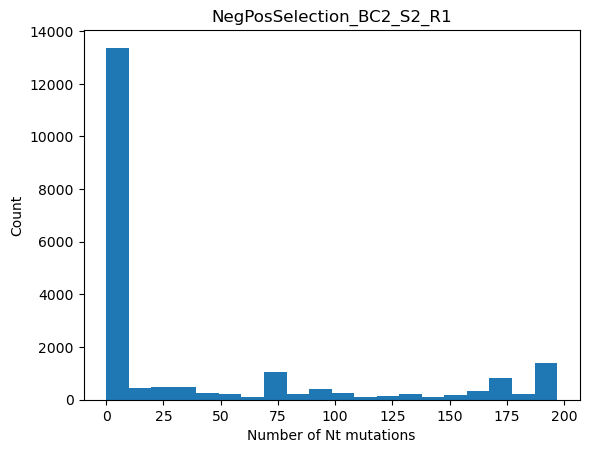

Nt mutations {0: 12879, 1: 192, 2: 69, 3: 68, 4: 127, 5: 91, 6: 22, 7: 33, 8: 11, 9: 255, 10: 133, 11: 19, 12: 20, 13: 40, 14: 8, 15: 17, 16: 33, 17: 44, 18: 27, 19: 32, 20: 15, 21: 207, 22: 136, 23: 13, 24: 208, 25: 12, 26: 25, 27: 38, 28: 35, 29: 86, 30: 17, 31: 127, 32: 69, 33: 40, 34: 24, 35: 56, 36: 45, 37: 28, 38: 18, 39: 29, 40: 14, 41: 17, 42: 11, 43: 8, 44: 10, 45: 13, 46: 13, 47: 10, 48: 8, 49: 7, 50: 32, 51: 23, 52: 155, 53: 21, 54: 30, 55: 10, 56: 25, 57: 33, 58: 22, 59: 17, 60: 10, 61: 14, 62: 31, 63: 13, 64: 12, 65: 5, 66: 3, 67: 14, 68: 9, 69: 13, 70: 7, 71: 25, 72: 46, 73: 10, 74: 8, 75: 14, 76: 22, 77: 16, 78: 56, 79: 24, 80: 7, 81: 1, 82: 68, 83: 799, 84: 36, 85: 40, 86: 10, 87: 12, 88: 20, 89: 29, 90: 6, 91: 49, 92: 12, 93: 52, 94: 76, 95: 51, 96: 16, 97: 27, 98: 32, 99: 11, 100: 31, 101: 17, 102: 31, 103: 22, 104: 11, 105: 12, 106: 4, 107: 5, 108: 4, 109: 10, 110: 3, 111: 27, 112: 13, 113: 15, 114: 10, 115: 3, 116: 4, 117: 12, 118: 5, 119: 16, 120: 3, 121: 13, 122: 

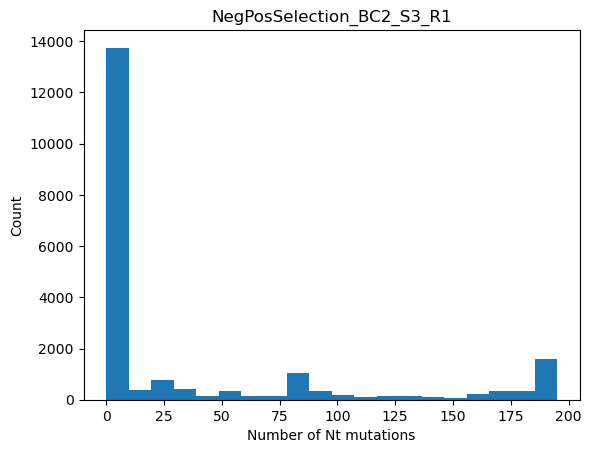

Nt mutations {0: 12891, 1: 233, 2: 92, 3: 128, 4: 85, 5: 64, 6: 30, 7: 26, 8: 98, 9: 47, 10: 29, 11: 35, 12: 29, 13: 61, 14: 14, 15: 24, 16: 19, 17: 21, 18: 49, 19: 219, 20: 29, 21: 51, 22: 19, 23: 12, 24: 208, 25: 18, 26: 47, 27: 72, 28: 25, 29: 44, 30: 93, 31: 81, 32: 100, 33: 93, 34: 18, 35: 21, 36: 35, 37: 6, 38: 19, 39: 23, 40: 13, 41: 28, 42: 16, 43: 1, 44: 8, 45: 21, 46: 18, 47: 17, 48: 14, 49: 8, 50: 6, 51: 5, 52: 8, 53: 14, 54: 29, 55: 21, 56: 7, 57: 19, 58: 50, 59: 12, 60: 31, 61: 10, 62: 14, 63: 20, 64: 26, 65: 8, 66: 7, 67: 16, 68: 7, 69: 6, 70: 9, 71: 5, 72: 1, 73: 12, 74: 14, 75: 6, 76: 17, 77: 75, 78: 814, 79: 42, 80: 8, 81: 19, 82: 47, 83: 64, 84: 31, 85: 9, 86: 8, 87: 23, 88: 10, 89: 21, 90: 2, 91: 22, 92: 13, 93: 62, 94: 103, 95: 190, 96: 16, 97: 62, 98: 25, 99: 16, 100: 15, 101: 16, 102: 24, 103: 10, 104: 10, 105: 12, 106: 3, 107: 14, 108: 15, 109: 14, 110: 1, 111: 4, 112: 19, 113: 11, 114: 10, 115: 6, 116: 4, 117: 5, 118: 5, 119: 6, 120: 4, 121: 11, 122: 15, 123: 25

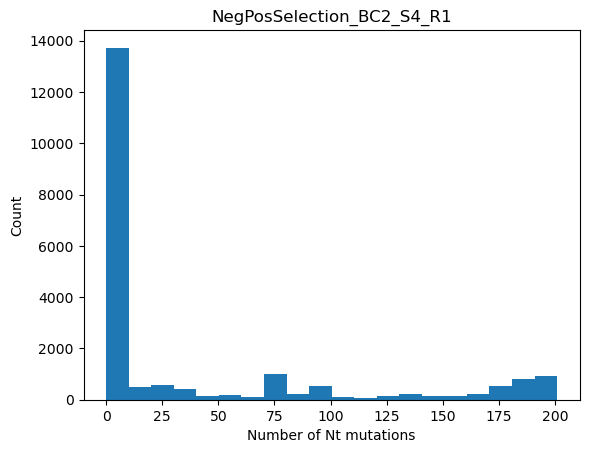

Nt mutations {0: 14803, 1: 104, 2: 40, 3: 68, 4: 113, 5: 121, 6: 49, 7: 50, 8: 17, 9: 124, 10: 33, 11: 125, 12: 19, 13: 13, 14: 12, 15: 37, 16: 45, 17: 32, 18: 19, 19: 12, 20: 15, 21: 125, 22: 6, 23: 41, 24: 223, 25: 9, 26: 23, 27: 4, 28: 29, 29: 8, 30: 20, 31: 45, 32: 40, 33: 36, 34: 13, 35: 18, 36: 14, 37: 9, 38: 12, 39: 17, 40: 10, 41: 6, 42: 5, 43: 4, 44: 6, 45: 8, 46: 7, 47: 17, 48: 10, 49: 52, 50: 15, 51: 9, 52: 7, 53: 12, 54: 16, 55: 12, 56: 10, 57: 9, 58: 7, 59: 123, 60: 13, 61: 6, 62: 52, 63: 26, 64: 10, 65: 8, 66: 6, 67: 30, 68: 11, 69: 21, 70: 8, 71: 55, 72: 63, 73: 8, 74: 5, 75: 17, 76: 136, 77: 12, 78: 5, 79: 15, 80: 2, 81: 10, 82: 8, 83: 47, 84: 20, 85: 126, 86: 35, 87: 12, 88: 15, 89: 24, 90: 6, 91: 72, 92: 51, 93: 22, 94: 22, 95: 27, 96: 40, 97: 93, 98: 25, 99: 60, 100: 452, 101: 26, 102: 24, 103: 21, 104: 34, 105: 11, 106: 18, 107: 19, 108: 15, 109: 8, 110: 28, 111: 3, 112: 3, 113: 9, 114: 2, 115: 8, 116: 8, 117: 20, 118: 6, 119: 3, 120: 14, 121: 16, 122: 26, 123: 16, 

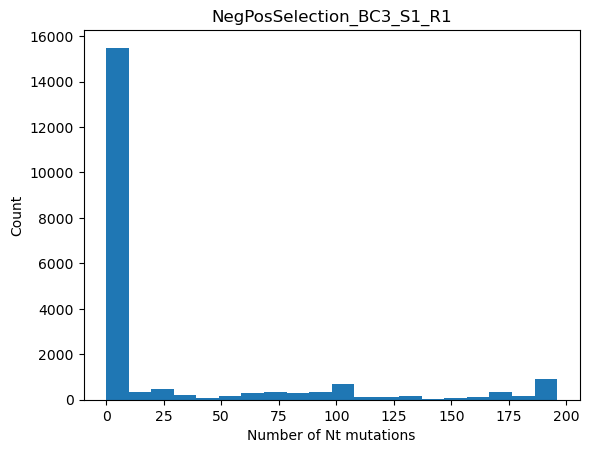

Nt mutations {0: 14574, 1: 218, 2: 86, 3: 110, 4: 101, 5: 27, 6: 30, 7: 118, 8: 16, 9: 31, 10: 41, 11: 51, 12: 44, 13: 29, 14: 124, 15: 12, 16: 24, 17: 20, 18: 12, 19: 75, 20: 172, 21: 151, 22: 26, 23: 21, 24: 4, 25: 6, 26: 4, 27: 6, 28: 4, 29: 6, 30: 48, 31: 12, 32: 34, 33: 28, 34: 17, 35: 48, 36: 10, 37: 8, 38: 12, 39: 6, 40: 7, 41: 8, 42: 9, 43: 8, 44: 6, 45: 55, 46: 6, 47: 3, 48: 10, 49: 17, 50: 19, 51: 9, 52: 15, 53: 15, 54: 12, 55: 3, 56: 7, 57: 10, 58: 16, 59: 5, 60: 14, 61: 3, 62: 22, 63: 123, 64: 45, 65: 13, 66: 16, 67: 10, 68: 5, 69: 26, 70: 10, 71: 16, 72: 8, 73: 24, 74: 48, 75: 82, 76: 33, 77: 24, 78: 25, 79: 12, 80: 124, 81: 21, 82: 7, 83: 10, 84: 27, 85: 21, 86: 14, 87: 56, 88: 155, 89: 52, 90: 32, 91: 27, 92: 34, 93: 30, 94: 25, 95: 65, 96: 34, 97: 13, 98: 59, 99: 77, 100: 25, 101: 26, 102: 12, 103: 76, 104: 442, 105: 26, 106: 11, 107: 7, 108: 8, 109: 14, 110: 2, 111: 1, 112: 2, 113: 8, 114: 20, 115: 25, 116: 20, 117: 12, 118: 9, 119: 9, 120: 7, 121: 15, 122: 15, 123: 19

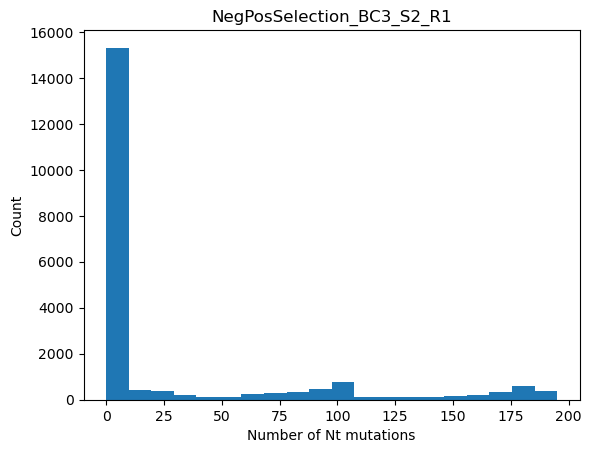

Nt mutations {0: 14684, 1: 201, 2: 41, 3: 166, 4: 107, 5: 50, 6: 25, 7: 23, 8: 7, 9: 123, 10: 77, 11: 47, 12: 29, 13: 145, 14: 9, 15: 6, 16: 214, 17: 24, 18: 34, 19: 5, 20: 11, 21: 108, 22: 82, 23: 12, 24: 157, 25: 14, 26: 31, 27: 11, 28: 17, 29: 18, 30: 15, 31: 4, 32: 6, 33: 4, 34: 7, 35: 39, 36: 13, 37: 10, 38: 3, 39: 16, 40: 10, 41: 7, 42: 3, 43: 10, 44: 11, 45: 1, 46: 4, 47: 4, 48: 22, 49: 5, 50: 25, 51: 11, 52: 68, 53: 14, 54: 18, 55: 7, 56: 19, 57: 33, 58: 15, 59: 7, 60: 8, 61: 112, 62: 13, 63: 7, 64: 2, 65: 39, 66: 11, 67: 15, 68: 11, 69: 9, 70: 29, 71: 91, 72: 98, 73: 20, 74: 17, 75: 16, 76: 8, 77: 22, 78: 141, 79: 16, 80: 4, 81: 2, 82: 11, 83: 10, 84: 46, 85: 24, 86: 11, 87: 128, 88: 74, 89: 26, 90: 16, 91: 49, 92: 38, 93: 18, 94: 26, 95: 53, 96: 40, 97: 29, 98: 40, 99: 26, 100: 19, 101: 49, 102: 406, 103: 72, 104: 12, 105: 7, 106: 15, 107: 12, 108: 2, 109: 12, 110: 15, 111: 28, 112: 17, 113: 12, 114: 7, 115: 13, 116: 2, 117: 5, 118: 17, 119: 18, 120: 19, 121: 10, 122: 12, 123

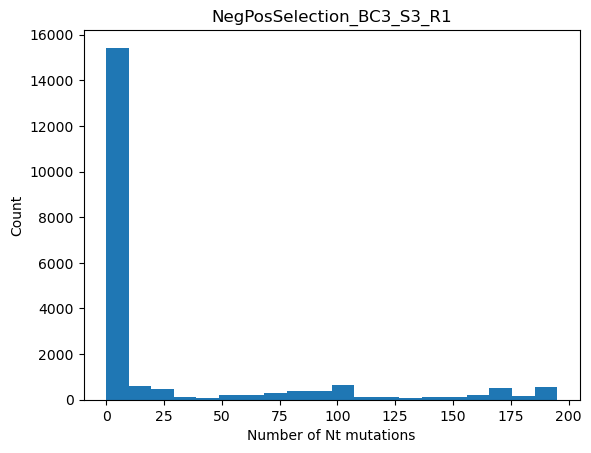

Nt mutations {0: 14596, 1: 263, 2: 121, 3: 75, 4: 137, 5: 65, 6: 24, 7: 28, 8: 17, 9: 16, 10: 53, 11: 27, 12: 172, 13: 40, 14: 36, 15: 19, 16: 14, 17: 12, 18: 39, 19: 114, 20: 13, 21: 46, 22: 168, 23: 9, 24: 136, 25: 11, 26: 44, 27: 16, 28: 3, 29: 8, 30: 4, 31: 17, 32: 8, 33: 76, 34: 8, 35: 36, 36: 13, 37: 7, 38: 18, 39: 16, 40: 11, 41: 15, 42: 10, 43: 4, 44: 10, 45: 5, 46: 4, 47: 22, 48: 14, 49: 8, 50: 3, 51: 9, 52: 3, 53: 6, 54: 11, 55: 19, 56: 5, 57: 4, 58: 27, 59: 3, 60: 116, 61: 11, 62: 7, 63: 49, 64: 21, 65: 15, 66: 18, 67: 33, 68: 23, 69: 14, 70: 54, 71: 63, 72: 7, 73: 7, 74: 9, 75: 12, 76: 12, 77: 174, 78: 19, 79: 11, 80: 4, 81: 9, 82: 7, 83: 32, 84: 50, 85: 12, 86: 131, 87: 43, 88: 46, 89: 43, 90: 33, 91: 25, 92: 11, 93: 30, 94: 29, 95: 104, 96: 33, 97: 40, 98: 82, 99: 443, 100: 38, 101: 14, 102: 22, 103: 9, 104: 15, 105: 18, 106: 11, 107: 6, 108: 9, 109: 7, 110: 10, 111: 1, 112: 15, 113: 27, 114: 3, 115: 2, 116: 3, 117: 2, 118: 5, 119: 5, 120: 14, 121: 5, 122: 6, 123: 10, 124

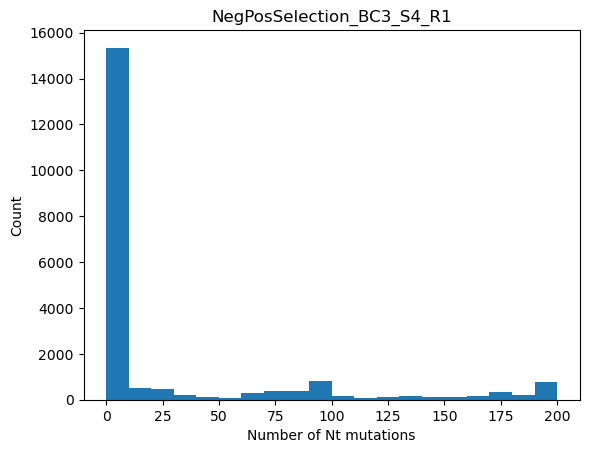

Nt mutations {0: 7141, 1: 305, 2: 57, 3: 227, 4: 41, 5: 63, 6: 326, 7: 37, 8: 18, 9: 376, 10: 92, 11: 33, 12: 21, 13: 43, 14: 31, 15: 78, 16: 24, 17: 210, 18: 43, 19: 47, 20: 22, 21: 64, 22: 7, 23: 15, 24: 74, 25: 67, 26: 36, 27: 49, 28: 92, 29: 40, 30: 48, 31: 73, 32: 533, 33: 34, 34: 16, 35: 6, 36: 8, 37: 27, 38: 360, 39: 22, 40: 13, 41: 7, 42: 8, 43: 65, 44: 18, 45: 12, 46: 25, 47: 9, 48: 40, 49: 54, 50: 19, 51: 15, 52: 14, 53: 26, 54: 14, 55: 13, 56: 9, 57: 22, 58: 9, 59: 32, 60: 19, 61: 214, 62: 251, 63: 23, 64: 24, 65: 16, 66: 25, 67: 26, 68: 11, 69: 16, 70: 66, 71: 66, 72: 18, 73: 60, 74: 36, 75: 37, 76: 53, 77: 31, 78: 28, 79: 20, 80: 25, 81: 11, 82: 12, 83: 46, 84: 16, 85: 110, 86: 32, 87: 83, 88: 48, 89: 49, 90: 29, 91: 116, 92: 33, 93: 20, 94: 26, 95: 30, 96: 34, 97: 60, 98: 52, 99: 49, 100: 48, 101: 55, 102: 43, 103: 76, 104: 59, 105: 49, 106: 9, 107: 14, 108: 16, 109: 18, 110: 29, 111: 17, 112: 41, 113: 30, 114: 14, 115: 24, 116: 31, 117: 43, 118: 54, 119: 49, 120: 41, 121

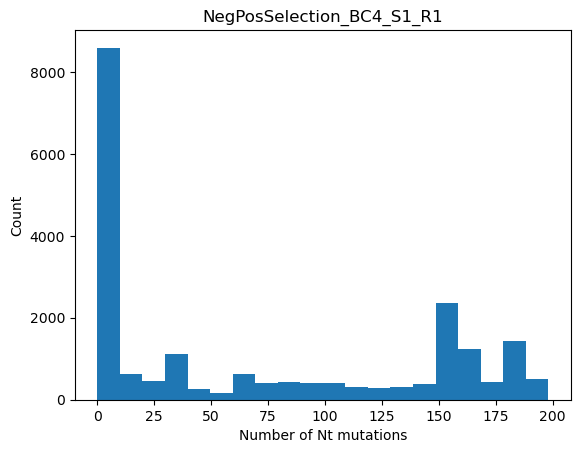

Nt mutations {0: 7256, 1: 127, 2: 132, 3: 80, 4: 121, 5: 37, 6: 317, 7: 217, 8: 123, 9: 8, 10: 195, 11: 27, 12: 47, 13: 28, 14: 17, 15: 8, 16: 85, 17: 22, 18: 27, 19: 186, 20: 46, 21: 120, 22: 33, 23: 40, 24: 14, 25: 15, 26: 33, 27: 25, 28: 39, 29: 52, 30: 62, 31: 27, 32: 40, 33: 68, 34: 21, 35: 88, 36: 349, 37: 72, 38: 486, 39: 78, 40: 17, 41: 12, 42: 8, 43: 29, 44: 11, 45: 86, 46: 19, 47: 31, 48: 8, 49: 14, 50: 12, 51: 28, 52: 15, 53: 31, 54: 18, 55: 15, 56: 10, 57: 13, 58: 12, 59: 13, 60: 24, 61: 46, 62: 211, 63: 238, 64: 21, 65: 11, 66: 17, 67: 33, 68: 64, 69: 21, 70: 77, 71: 53, 72: 53, 73: 27, 74: 20, 75: 35, 76: 45, 77: 48, 78: 29, 79: 152, 80: 67, 81: 70, 82: 58, 83: 39, 84: 29, 85: 59, 86: 68, 87: 39, 88: 29, 89: 20, 90: 16, 91: 31, 92: 30, 93: 17, 94: 31, 95: 120, 96: 23, 97: 20, 98: 52, 99: 89, 100: 39, 101: 53, 102: 60, 103: 60, 104: 50, 105: 58, 106: 55, 107: 17, 108: 9, 109: 36, 110: 48, 111: 37, 112: 21, 113: 12, 114: 15, 115: 41, 116: 17, 117: 20, 118: 27, 119: 24, 120:

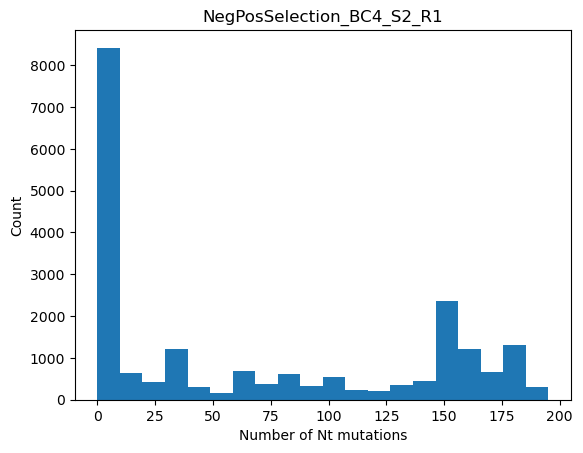

Nt mutations {0: 7150, 1: 322, 2: 64, 3: 107, 4: 117, 5: 115, 6: 17, 7: 22, 8: 22, 9: 508, 10: 61, 11: 92, 12: 149, 13: 68, 14: 37, 15: 39, 16: 25, 17: 35, 18: 64, 19: 10, 20: 27, 21: 235, 22: 85, 23: 13, 24: 80, 25: 25, 26: 28, 27: 13, 28: 22, 29: 30, 30: 93, 31: 32, 32: 59, 33: 36, 34: 57, 35: 115, 36: 457, 37: 70, 38: 10, 39: 28, 40: 18, 41: 367, 42: 8, 43: 16, 44: 63, 45: 17, 46: 28, 47: 22, 48: 33, 49: 16, 50: 11, 51: 20, 52: 52, 53: 30, 54: 24, 55: 11, 56: 24, 57: 26, 58: 14, 59: 25, 60: 23, 61: 7, 62: 211, 63: 243, 64: 25, 65: 26, 66: 19, 67: 15, 68: 63, 69: 36, 70: 18, 71: 47, 72: 25, 73: 81, 74: 27, 75: 52, 76: 22, 77: 30, 78: 24, 79: 50, 80: 19, 81: 43, 82: 29, 83: 13, 84: 40, 85: 37, 86: 25, 87: 9, 88: 10, 89: 99, 90: 49, 91: 106, 92: 48, 93: 38, 94: 36, 95: 41, 96: 54, 97: 52, 98: 30, 99: 30, 100: 21, 101: 17, 102: 77, 103: 30, 104: 62, 105: 55, 106: 130, 107: 42, 108: 18, 109: 19, 110: 22, 111: 33, 112: 34, 113: 66, 114: 35, 115: 19, 116: 28, 117: 12, 118: 35, 119: 30, 120

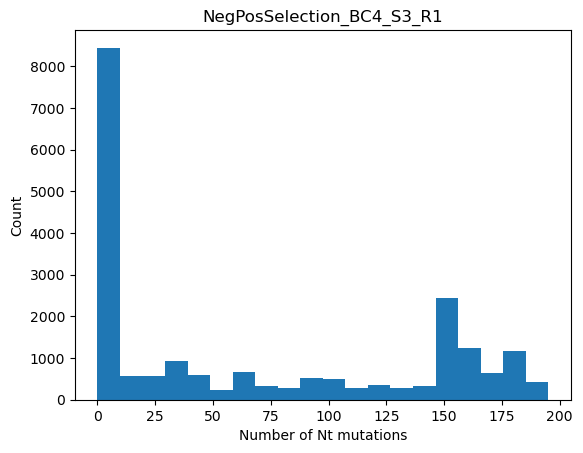

Nt mutations {0: 7123, 1: 429, 2: 82, 3: 128, 4: 117, 5: 110, 6: 28, 7: 48, 8: 340, 9: 21, 10: 151, 11: 35, 12: 131, 13: 46, 14: 102, 15: 24, 16: 48, 17: 32, 18: 74, 19: 57, 20: 153, 21: 51, 22: 32, 23: 34, 24: 149, 25: 50, 26: 30, 27: 31, 28: 17, 29: 20, 30: 51, 31: 55, 32: 45, 33: 50, 34: 17, 35: 37, 36: 38, 37: 14, 38: 20, 39: 536, 40: 21, 41: 357, 42: 20, 43: 32, 44: 16, 45: 12, 46: 8, 47: 13, 48: 69, 49: 23, 50: 23, 51: 15, 52: 14, 53: 16, 54: 9, 55: 12, 56: 12, 57: 25, 58: 23, 59: 3, 60: 7, 61: 12, 62: 20, 63: 40, 64: 29, 65: 20, 66: 213, 67: 245, 68: 35, 69: 17, 70: 35, 71: 20, 72: 6, 73: 20, 74: 63, 75: 16, 76: 72, 77: 48, 78: 45, 79: 18, 80: 69, 81: 20, 82: 32, 83: 31, 84: 61, 85: 28, 86: 37, 87: 27, 88: 10, 89: 22, 90: 120, 91: 24, 92: 9, 93: 60, 94: 56, 95: 102, 96: 96, 97: 58, 98: 40, 99: 43, 100: 39, 101: 46, 102: 100, 103: 58, 104: 20, 105: 34, 106: 12, 107: 73, 108: 18, 109: 74, 110: 17, 111: 22, 112: 36, 113: 29, 114: 22, 115: 12, 116: 13, 117: 21, 118: 23, 119: 16, 120

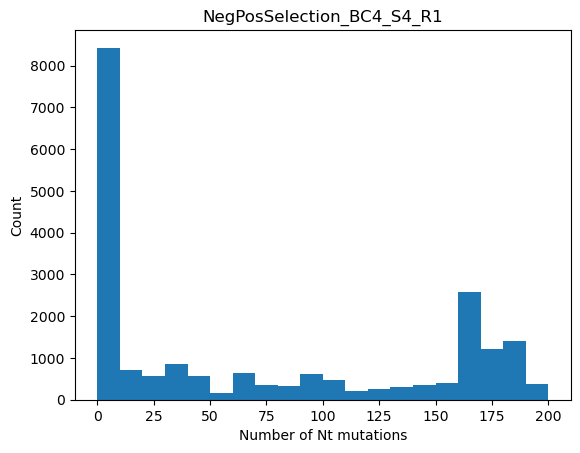

<Figure size 640x480 with 0 Axes>

In [203]:

Step ="NegPosSelection"
used_Barcodes = ["BC1", "BC2", "BC3", "BC4"]
Section = "S1"
for Bc in used_Barcodes:
    for Section in Sections: 
        a_reads = all_reads[f"{Step}_{Bc}_{Section}_R1"]
        b_reads = all_reads[f"{Step}_{Bc}_{Section}_R2"]
        ref_seq_Section = ref_gene[ref_gene.index(Primer_seq[f"{Section}_fwd_primer"]):ref_gene.index(dna_rev_comp(Primer_seq[f"{Section}_rev_primer"]))+len(Primer_seq[f"{Section}_rev_primer"])]
        ## calculate and plot the number of Nt and Codon mutations per sequence

        seq_n_Nt_mutations = gather_n_mutations(a_seq, b_seq, catch_left=Barcodes[f"{Bc}_Fwd"],catch_right=[f"{Bc}_Rev"],  reference_seq = ref_seq_Section, use_backward_read=False, use_triplets=False)
        seq_n_Nt_mutations = dict(sorted(seq_n_Nt_mutations.items())) ## sort dictionary after key

        #seq_n_Codon_mutations = gather_n_mutations(a_seq, b_seq, reference_seq = LOV_gene, use_backward_read=use_backward_read, use_triplets=True, treshold = treshold)
        #seq_n_Codon_mutations = dict(sorted(seq_n_Codon_mutations.items())) ## sort dictionary after key

        print("Nt mutations", seq_n_Nt_mutations)
        #print("Codon mutations", seq_n_Codon_mutations)
        plt.hist(seq_n_Nt_mutations.keys(), weights=seq_n_Nt_mutations.values(), bins = 20)
        plt.xlabel("Number of Nt mutations")
        plt.ylabel("Count")
        plt.title(f"{Step}_{Bc}_{Section}_R1")
        plt.show()
        plt.clf()